<h1> Give Me Some Credit - Kaggle Competition </h1>

Kaggle competition to "improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years."

Models fit:
* Logistic Regression
* Random Forest
* XGBoost
* TPOT (AutoML in scikit-learn)

SMOTE is used to over-sample the data since it's very imbalanced but did not improve results and the XGBoost model learned using TPOT was found to perform best with a ROC AUC of 0.8649

https://www.kaggle.com/c/GiveMeSomeCredit

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [5]:
from xgboost import XGBClassifier

/Users/alex/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
from tpot import TPOTClassifier

In [7]:
import autokeras as ak

# Load & explore data

## Load data

In [9]:
df = pd.read_csv('data/cs-training.csv', index_col = 0)

In [10]:
df.head().T

,1,2,3,4,5
SeriousDlqin2yrs,1.000000,0.000000,0.000000,0.00000,0.000000
RevolvingUtilizationOfUnsecuredLines,0.766127,0.957151,0.658180,0.23381,0.907239
age,45.000000,40.000000,38.000000,30.00000,49.000000
NumberOfTime30-59DaysPastDueNotWorse,2.000000,0.000000,1.000000,0.00000,1.000000
DebtRatio,0.802982,0.121876,0.085113,0.03605,0.024926
MonthlyIncome,9120.000000,2600.000000,3042.000000,3300.00000,63588.000000
NumberOfOpenCreditLinesAndLoans,13.000000,4.000000,2.000000,5.00000,7.000000
NumberOfTimes90DaysLate,0.000000,0.000000,1.000000,0.00000,0.000000
NumberRealEstateLoansOrLines,6.000000,0.000000,0.000000,0.00000,1.000000
NumberOfTime60-89DaysPastDueNotWorse,0.000000,0.000000,0.000000,0.00000,0.000000


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


> very high max values for `DebtRatio, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse` - likely outliers

In [12]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

> missing values for MonthlyIncome might be responsible for very high debt ratios.

## Explore target variable SeriousDlqin2yrs

In [13]:
df['SeriousDlqin2yrs'].mean()

0.06684

> only ±6.5% of target variable is positive - very imbalanced. Might want to oversample...

## Explore debt ratio vs. monthly income

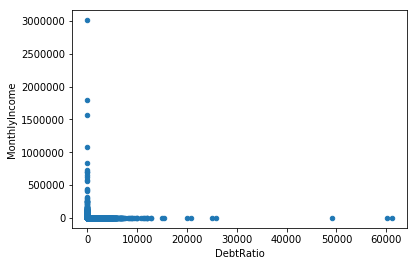

In [14]:
df.plot.scatter(x='DebtRatio', y = "MonthlyIncome")

> very high debt ratios have 0 monthly income which (makes sense since debt ratio = monthly debt payments, alimony,living costs divided by monthy gross income)

(0, 10)

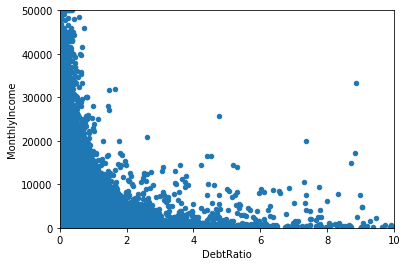

In [15]:
ax = df.plot.scatter(x='DebtRatio', y = "MonthlyIncome")
ax.set_ylim([0,50000])
ax.set_xlim([0,10])

In [16]:
df[df['DebtRatio'] > 10][['SeriousDlqin2yrs', 'MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,28877.000000,2106.000000
mean,0.055719,118.451567
std,0.229382,962.739430
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,16500.000000


> the 75th percentile monthly income is 1 for high debt ratio individuals which makes sense but it's odd to have a monthly income of 1, likely a data entry issue - these should probably actually be "missing"

## Explore NumberOfTimes90DaysLate

In [17]:
df['NumberOfTimes90DaysLate'].value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

> weird that there are no individuals with number of days late between 17 and 96 but so many at 98.

In [18]:
df[df['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs']].describe()

,SeriousDlqin2yrs
count,269.000000
mean,0.546468
std,0.498764
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


> The individuals who are more than 90 days late over 95 times have a very high delinquincy rate so we shouldn't drop these as outliers... should probably truncate them.

## Explore NumberOfTime60-89DaysPastDueNotWorse

In [19]:
df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts().sort_index()

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [20]:
df[df['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs']].describe()

,SeriousDlqin2yrs
count,269.000000
mean,0.546468
std,0.498764
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


> Similar story to more than 90 days late - should probably truncate.

# Clean data & format for models

## clean data

In [21]:
dft = df.copy()

In [22]:
# convert monthly income 1 to missing
dft.loc[dft['MonthlyIncome'] == 1, 'MonthlyIncome'] = np.nan
# create missingness indicator - likely missing not at random
dft['MonthlyIncomeMissing'] = dft['MonthlyIncome'].isnull().astype(int)
# fill missing income with median income
dft['MonthlyIncome'].fillna(dft['MonthlyIncomeMissing'].median(), inplace=True)

In [23]:
# drop outlier debt ratio
dft = dft.drop(dft[dft['DebtRatio'] > dft['DebtRatio'].quantile(0.975)].index)

In [24]:
# fill missing dependents with 0
dft['NumberOfDependents'].fillna(0, inplace=True)

## format for models

In [25]:
# create features and target to fit models
X = dft.drop(['SeriousDlqin2yrs'], axis=1)
y = dft['SeriousDlqin2yrs']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, train_size=0.8, test_size=0.2)

In [50]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_n = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test_n = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# Fit Logistic Regression

In [25]:
clf = LogisticRegression(random_state=0, max_iter=5000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=0)

In [26]:
roc_auc_score(y_test, np.array(clf.predict_proba(X_test))[:,1])

0.704515581322596

## re-fit using statsmodels to see which variables are significant

In [40]:
sm_model = sm.Logit(y_train.values.reshape(-1,1), sm.add_constant(X_train_n)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

const                                    0.000000e+00
RevolvingUtilizationOfUnsecuredLines     4.563395e-01
age                                     1.245570e-193
NumberOfTime30-59DaysPastDueNotWorse     0.000000e+00
DebtRatio                                1.342968e-06
MonthlyIncome                            3.083106e-22
NumberOfOpenCreditLinesAndLoans          5.002293e-02
NumberOfTimes90DaysLate                 1.988798e-175
NumberRealEstateLoansOrLines             1.388142e-05
NumberOfTime60-89DaysPastDueNotWorse     0.000000e+00
NumberOfDependents                       9.248012e-25
MonthlyIncomeMissing                     3.069353e-02
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               117000
Model:                          Logit   Df Residuals:                   116988
Method:                           MLE   Df Model:                           11
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.08317
Time:                        16:29:35   Log-Likelihood:                -26445.
converged:                       True   LL-Null:                       -28844.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.8513      0.014   -206.909      0.000      -2.878      -2.824
RevolvingUtilizationOfUnsecuredLines    -0.0149      0.020     -0.745      0.456      -0.054       0.024
age                                     -0.4116      0.014    -29.684      0.000      -0.439      -0.384
NumberOfTime30-59DaysPastDueNotWorse     2.0850      0.054     38.724      0.000       1.979       2.191
DebtRatio                               -0.0925      0.019     -4.833      0.000      -0.130      -0.055
MonthlyIncome                           -0.4866      0.050     -9.698      0.000      -0.585      -0.388
NumberOfOpenCreditLinesAndLoans         -0.0288      0.015     -1.960      0.050      -0.058    2.89e-06
NumberOfTimes90DaysLate                  2.0530      0.073     28.238      0.000       1.910       2.195
NumberRealEstateLoansOrLines             0.0587      0.014      4.346      0.000       0.032       0.085
NumberOfTime60-89DaysPastDueNotWorse    -3.9765      0.085    -47.044      0.000      -4.142      -3.811
NumberOfDependents                       0.1176      0.011     10.274      0.000       0.095       0.140
MonthlyIncomeMissing                    -0.0416      0.019     -2.161      0.031      -0.079      -0.004
========================================================================================================
"""

# Fit Random Forest

## find optimal parameters

In [130]:
best = 0
best_res = ""
for i in range(5,25):
    for j in range(5,25):
        rfc = RandomForestClassifier(n_estimators=i,max_depth=j, random_state=0)
        s = cross_validate(rfc, X, y, scoring=['roc_auc'], cv=4, n_jobs=-1)
        res = "n_estimators={}, depth={}, roc_auc={}".format(i,j,s['test_roc_auc'][0])
        if s['test_roc_auc'][0] > best:
            best = s['test_roc_auc'][0]
            best_res = res
print(best_res)

n_estimators=24, depth=10, roc_auc=0.8613158924650011


> best model: n_estimators=24, depth=10, roc_auc=0.8613

## compute roc auc on test set

In [196]:
rfc = RandomForestClassifier(n_estimators=24,max_depth=10, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [197]:
roc_auc_score(y_test, np.array(rfc.predict_proba(X_test))[:,1])

0.8674271206686976

> Much better ROC AUC than logistic regression

## view feature importances

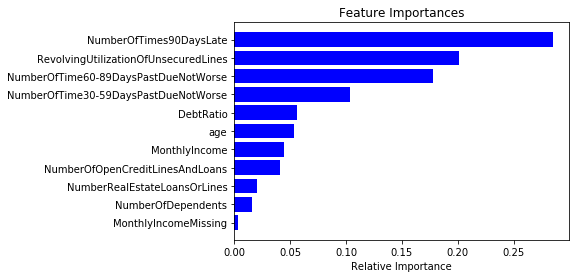

In [138]:
features = list(X.columns)
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Fit XGBoost

## find optimal parameters

In [174]:
steps = list(2**i for i in range(1,5))

In [44]:
best = 0
best_res = ""
for i in steps:
    for j in steps:
        xgb = XGBClassifier(eval_metric='auc', minchildweight=i, max_depth=j)
        s = cross_validate(xgb, X, y, scoring=['roc_auc'], cv=4, n_jobs=-1)
        res = "minchildweight={}, max_depth={}, roc_auc={}".format(i,j,s['test_roc_auc'][0])
        if s['test_roc_auc'][0] > best:
            best = s['test_roc_auc'][0]
            best_res = res
print(best_res)

> best model: 'minchildweight=2, max_depth=2, roc_auc=0.8625866942956544'

## compute roc auc on test set

In [184]:
xgb = XGBClassifier(eval_metric='auc', minchildweight=2, max_depth=2)
xgb.fit(X_train, y_train)

[20:29:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { minchildweight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='auc', gamma=0,
       gpu_id=-1, importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, minchildweight=2, missing=nan,
       monotone_constraints='()', n_estimators=100, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [195]:
roc_auc_score(y_test, np.array(xgb.predict_proba(X_test))[:,1])

0.8671301470305899

> surprisingly slightly worse than Random Forest but approximately the same 0.8671 vs 0.8674

## view feature importances

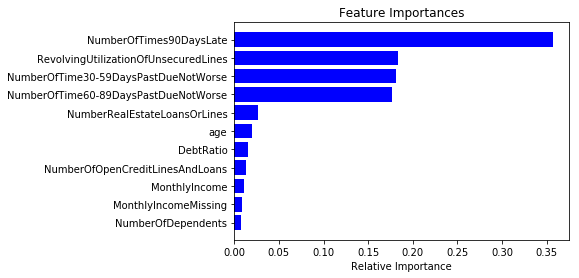

In [183]:
features = list(X.columns)
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

> the top 4 features are the same but some differences vs. random forest in other features' importances

# Fit TPOT - AutoML for sklearn pipelines

In [37]:
tpot = TPOTClassifier(generations = 100, population_size=100, n_jobs=-1, scoring='roc_auc', verbosity=2)

In [38]:
tpot.fit(X_train,y_train)

A Jupyter Widget


Generation 1 - Current best internal CV score: 0.866934017913907
Generation 2 - Current best internal CV score: 0.866934017913907
Generation 3 - Current best internal CV score: 0.8670146370798708
Generation 4 - Current best internal CV score: 0.8670146370798708
Generation 5 - Current best internal CV score: 0.8671638216042334
Generation 6 - Current best internal CV score: 0.8671638216042334
Generation 7 - Current best internal CV score: 0.8672263527428704
Generation 8 - Current best internal CV score: 0.8673146888038448
Generation 9 - Current best internal CV score: 0.8673146888038448
Generation 10 - Current best internal CV score: 0.8674992504779162
Generation 11 - Current best internal CV score: 0.86770967560216
Generation 12 - Current best internal CV score: 0.8677741352329518
Generation 13 - Current best internal CV score: 0.8678288441264757
Generation 14 - Current best internal CV score: 0.8678288441264757
Generation 15 - Current best internal CV score: 0.8678288441264757
Generat

TPOTClassifier(log_file=<ipykernel.iostream.OutStream object at 0x7fc18e353a20>,
               n_jobs=-1, scoring='roc_auc', verbosity=2)

In [43]:
roc_auc_score(y_test, np.array(tpot.predict_proba(X_test))[:,1])

0.8649117004808518

> slightly better CV performance than RF and XGB but slightly worse on test set. Not surprising it's pretty much the same given the learned model is XGB around BernoulliNB features

# Create balanced dataset using SMOTE

In [34]:
from imblearn.over_sampling import BorderlineSMOTE

In [35]:
oversample = SMOTE(k_neighbors=5)

In [58]:
XX, yy = oversample.fit_resample(X_train, y_train)

In [64]:
scaler = preprocessing.StandardScaler().fit(XX)
X_train_n = pd.DataFrame(scaler.transform(XX), columns = X_train.columns)

In [65]:
X_test_n = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


# Re-fit XGB model on over-sampled dataset

In [70]:
xgb = XGBClassifier(eval_metric='auc', minchildweight=2, max_depth=2)
xgb.fit(X_train_n, yy)

[21:46:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { minchildweight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='auc', gamma=0,
       gpu_id=-1, importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, minchildweight=2, missing=nan,
       monotone_constraints='()', n_estimators=100, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
roc_auc_score(y_test, np.array(xgb.predict_proba(X_test_n))[:,1])

0.8554633278459169

> over-sampling reduced the AUC slightly - rather use the non-oversampled dataset 